# 3D Image Recovery Demo with Linear Bregman Iteration



by Xingjia Wang

Summary: The following notebook is a demonstration of using Linear Bregman Iteration to recover a random 3D image represented by a 3D numpy array. 

*Note: might have some bugs in 3D visualization (transparency,) but the rest should be working just as fine.

## Unit Import

In [1]:
import numpy as np

import scipy.ndimage                                           # Gaussian Kernel Units
import scipy.ndimage.filters as fi
import scipy.stats as st 

import matplotlib.pyplot as plt                                # Visualization Units
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from linBreg import *                                          # Linear Bregman Iteration Units

## Used Functions

### Kernel Generating Functions

- kern3d(klen, nsig): Returns a 3d Gaussian kernel
    
- kern3d_cross(klen): Returns a 3d cross-shaped kernel

In [3]:
'''
********* 3D Gaussian Kernel Generation ***********
type: function
return: 3d numpy array

Note: 3D Visualization has some bugs in transparency, but the kernel is correct.
'''
# Generating a 3d Gaussian kernel

def kern3d (klen, nsig):
    inp = np.zeros((klen, klen, klen))
    inp[klen//2, klen//2, klen//2] = 1
    return fi.gaussian_filter(inp,nsig)



In [4]:
'''
********* Cross-shaped Kernel Generation ********* 

type: function
return: 3d numpy array
'''

# Generating a 3d cross-shaped kernel
def kern3d_cross (klen):
    K1 = np.zeros((klen, klen, klen))
    half = klen//2
    K1[half,half,half] = 0.6
    K1[half,half,half+1] = 0.1
    K1[half,half+1,half] = 0.1
    K1[half,half-1,half] = 0.1
    K1[half,half,half-1] = 0.1
    return K1;
    

### Sensing Matrix Generating Function

- applyK_3d(A, K, n, binsize = 1):

    - A: 2D numpy array, shape: (n^3, n^3), zeros on all entries
    - K: 3D numpy array, shape: (n, n, n), kernel matrix
    - n: int, side length of the image
    - binsize: int, default value = 1

In [5]:
'''
*********** Sensing Matrix Generation ***********
type: function
return: 2d numpy array
'''

def applyK_3d(A, K, n, binsize = 1):
    #K_bin = binPixel(K[:len(K)-1,:len(K)-1],2)
    #size = K_bin//2
    #K_bin = np.append(K_bin[0], np.zeros(size))
    #K_bin = np.append(K_bin[1], np.zeros(size+1))
    x_n = n // binsize
    y_n = n
    kernal_half_width = len(K)//2
    for xind in np.arange(0,y_n):
        for yind in np.arange(0,y_n):
            for zind in np.arange(0, y_n):
                im = np.zeros((y_n,y_n,y_n))
                Ind = xind*y_n*y_n + yind*y_n + zind
                #print (Ind)
                im_x1 = np.max([xind - kernal_half_width, 0])
                im_x2 = np.min([xind + kernal_half_width, y_n])
                im_y1 = np.max([yind - kernal_half_width, 0])
                im_y2 = np.min([yind + kernal_half_width, y_n])
                im_z1 = np.max([zind - kernal_half_width, 0])
                im_z2 = np.min([zind + kernal_half_width, y_n])

                k_x1 = kernal_half_width - (xind - im_x1)
                k_x2 = kernal_half_width + (im_x2 - xind)
                k_y1 = kernal_half_width - (yind - im_y1)
                k_y2 = kernal_half_width + (im_y2 - yind)
                k_z1 = kernal_half_width - (zind - im_z1)
                k_z2 = kernal_half_width + (im_z2 - zind)

                im[im_x1:im_x2, im_y1:im_y2, im_z1:im_z2] = K[k_x1:k_x2, k_y1:k_y2, k_z1:k_z2]
                im = np.reshape(im, (y_n,y_n,y_n))
                A[:,Ind]=im.ravel()
    return A

## Initialization

### Visualization Settings

In [6]:
'''
********* Colormap Initialization ***********
return: my_cmap, a orange-gradient color map that sets the zero elements to be transparent. 

'''

# Choose colormap
cmap = pl.cm.Oranges

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[0:len(my_cmap[:,-1])//2,-1] = np.linspace(0, 1, cmap.N//2)


# Create new colormap
my_cmap = ListedColormap(my_cmap)

### Size Settings

In [7]:
n = 10                 # Side length
binsize = 2            # Size of binning
s = 5                  # Slice number

## Simulation Run

### Data Generation

In [8]:
# Kernel Generation
K_3d = kern3d(n+1, 2) 
K1 = kern3d_cross(n)

# Ground Truth Generation
x_3d = np.zeros((n,n,n)) 
midpoint = int(np.ceil(n/2))
idx = [3,5,7]
for i in idx:
    x_3d[i][np.random.randint(0,n-1)][np.random.randint(0,n-1)] = np.random.rand()
    
# Sensing Mx Generation - Gaussian
B = np.zeros((pow(n,3), pow(n,3)))
B = applyK_3d(B, K_3d, n)

# Sensing Mx Generation - Cross
C = np.zeros((pow(n,3), pow(n,3)))
C = applyK_3d(C, K1, n)

# Gaussian Blur Generation 
l_3d_B=np.matmul(B, x_3d.ravel())
im_3d_B = l_3d_B.reshape((n,n,n))

# Cross Blur Generation
l_3d_C=np.matmul(C, x_3d.ravel())
im_3d_C = l_3d_C.reshape((n,n,n))

# Blur Slice Selection
blur_slice_B = im_3d_B[s,:,:]
blur_slice_C = im_3d_C[s,:,:]

# Sensing Matrix Slice
x = range(s * 100,(s+1) * 100)
y = []
for i in range(10):
    y = np.append(y,list(range(i*100+s*10, i*100+(s+1)*10)))
y.ravel()
y = np.int_(y)
    
z = range(s,1000 + s, 10)

B_slice = B[x,:]
C_slice = C[x,:]

### Validity Check (Visualization)

#### Kernel

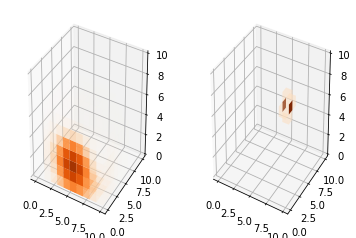

In [9]:
data_B = B[512].reshape((n,n,n))
data_C = C[584].reshape((n,n,n))

fig = plt.figure()
cmap = my_cmap
ax1 = fig.add_subplot(121, projection = '3d')
norm= plt.Normalize(data_B.min(),data_B.max())
ax1.patch.set_alpha(.5)
ax1.voxels(data_B, facecolors=cmap(norm(data_B)), edgecolor="none")

ax = fig.add_subplot(122,projection='3d')
norm1= plt.Normalize(data_C.min(), data_C.max())
ax.patch.set_alpha(.5)
ax.voxels(data_C, facecolors=cmap(norm1(data_C)), edgecolor="none")
plt.show()

#### Sensing Matrix Slice

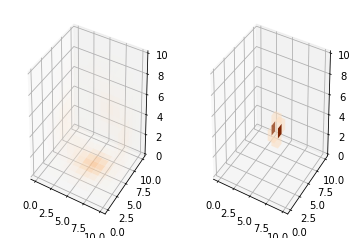

In [10]:
deB = B_slice[53].reshape(n,n,n)
deC = C_slice[53].reshape(n,n,n)

fig = plt.figure()
cmap = my_cmap
ax1 = fig.add_subplot(121, projection = '3d')
norm= plt.Normalize(deB.min(),deB.max())
ax1.patch.set_alpha(.5)
ax1.voxels(deB, facecolors=cmap(norm(deB)), edgecolor="none")
ax2 = fig.add_subplot(122, projection = '3d')
norm1= plt.Normalize(deC.min(),deC.max())
ax2.patch.set_alpha(.5)
ax2.voxels(deC, facecolors=cmap(norm1(deC)), edgecolor="none")
plt.show()

#### Blur (2D slices)

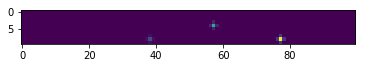

In [11]:
a = []
for i in range(n):
    a.append(im_3d_C[i,:,:])
image = np.concatenate(a, axis = 1)
plt.imshow(image)

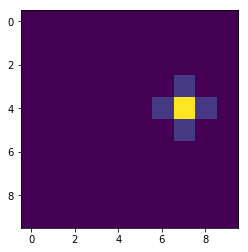

In [12]:
# Check if blur_slice contains non-zero parts

plt.imshow(blur_slice_C)

#### Blur (3D)

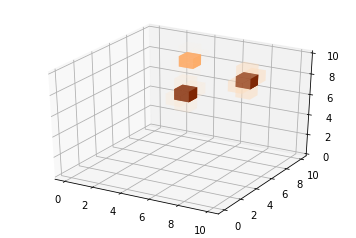

In [13]:
# Blur Validity Check - 3D Visualization
fig = plt.figure()
cmap = my_cmap
ax = fig.gca(projection='3d')
norm= plt.Normalize(im_3d_C.min(), im_3d_C.max())
ax.patch.set_alpha(.5)
ax.voxels(im_3d_C, facecolors=cmap(norm(im_3d_C)), edgecolor="none")
ax1 = fig.gca(projection='3d')
norm1= plt.Normalize(x_3d.min(), x_3d.max())
ax1.patch.set_alpha(.5)
ax1.voxels(x_3d, facecolors=cmap(norm(x_3d)), edgecolor="none")
plt.show()

### Recovery

- linbreg(im, sensmx, threshold=800, stepsize=1e-5, d=0.000012, minstep = 1000, maxstep = 1e6, crit = 1e-8, dim = 2):

    - im: 1D numpy array, vectorize blur
    
    - sensmx: 2D numpy array, sensing matrix
    
    - threshold: numerical value, default = 800
    
    - stepsize: numerical value, default = 1e-5
    
    - d: double, range = (0,1), default = 0.000012
    
    - minstep: integer, default = 1000, minimum rounds of iteration
    
    - maxstep: integer, default = 1e6, maximum rounds of iteration
    
    - crit: double, range = (0,1), default = 1e-8,  stopping condition
    
    - dim: integer, default = 2, dimension of recovered image   
    

#### Recovery with entire blur

10000
20000
30000
40000
50000


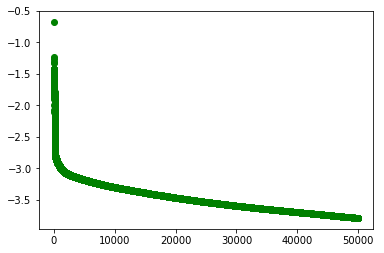

In [22]:
u_3d_B = linbreg(im_3d_B.ravel(), B, threshold= 2e9, stepsize = 1e-8, maxstep = 5e4, crit = 1e-6, dim = 3)

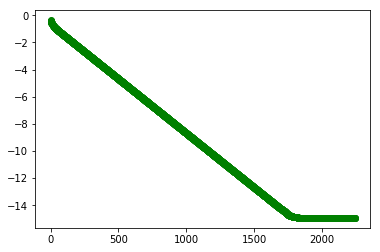

In [23]:
u_3d_C = linbreg(im_3d_C.ravel(), C, threshold= 1e8, stepsize = 1e-9, maxstep = 10000, crit = 1e-6, dim = 3)

#### Recovery with a 2D slice of blur

10000
20000
30000
40000
50000
60000
70000


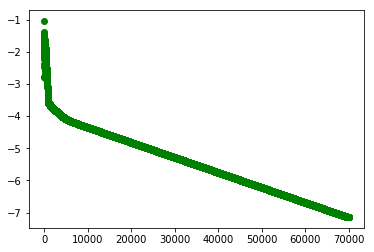

In [41]:
u_3d_Bs = linbreg(blur_slice_B.ravel(), B_slice, threshold= 1e7, stepsize = 1e-5, maxstep = 7e4, crit = 1e-6, dim = 3)

10000


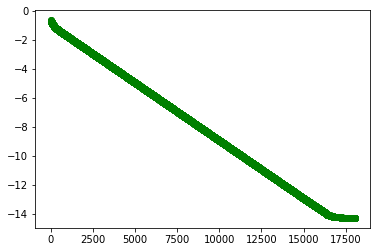

In [36]:
u_3d_Cs = linbreg(blur_slice_C.ravel(), C_slice, threshold= 1e7, stepsize = 1e-9, maxstep = 7e4, crit = 1e-6, dim = 3)

### Results Visualization

#### Recovery with entire blur

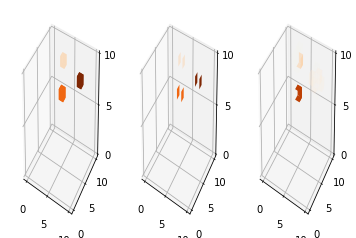

In [34]:
# Results Visualization
u_3d_C = u_3d_C.reshape((n,n,n))
u_3d_B = u_3d_B.reshape((n,n,n))

fig = plt.figure()
cmap = my_cmap
ax1 = fig.add_subplot(131, projection = '3d')
norm= plt.Normalize(x_3d.min(),x_3d.max())
ax1.patch.set_alpha(.5)
ax1.voxels(x_3d, facecolors=cmap(norm(x_3d)), edgecolor="none")

ax = fig.add_subplot(132,projection='3d')
norm1= plt.Normalize(u_3d_C.min(), u_3d_C.max())
ax.patch.set_alpha(.5)
ax.voxels(u_3d_C, facecolors=cmap(norm1(u_3d_C)), edgecolor="none")

ax0 = fig.add_subplot(133,projection='3d')
norm0= plt.Normalize(u_3d_B.min(), u_3d_B.max())
ax0.patch.set_alpha(.5)
ax0.voxels(u_3d_B, facecolors=cmap(norm0(u_3d_B)), edgecolor="none")
plt.show()

#### Recover with a 2D slice of blur

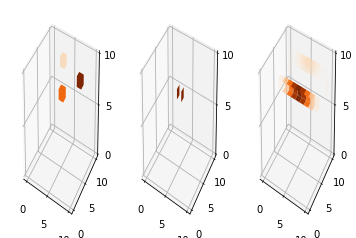

In [42]:
# Results Visualization 

u_3d_Cs = u_3d_Cs.reshape((n,n,n))
u_3d_Bs = u_3d_Bs.reshape((n,n,n))

fig = plt.figure()
cmap = my_cmap
ax1 = fig.add_subplot(131, projection = '3d')
norm= plt.Normalize(x_3d.min(),x_3d.max())
ax1.patch.set_alpha(.5)
ax1.voxels(x_3d, facecolors=cmap(norm(x_3d)), edgecolor="none")

ax = fig.add_subplot(132,projection='3d')
norm1= plt.Normalize(u_3d_Cs.min(), u_3d_Cs.max())
ax.patch.set_alpha(.5)
ax.voxels(u_3d_Cs, facecolors=cmap(norm1(u_3d_Cs)), edgecolor="none")

ax0 = fig.add_subplot(133,projection='3d')
norm0= plt.Normalize(B.min(), u_3d_Bs.max())
ax0.patch.set_alpha(.5)
ax0.voxels(u_3d_Bs, facecolors=cmap(norm0(u_3d_Bs)), edgecolor="none")
plt.show()